# Forgetting Factors for Online Inference

In this example, we explore a technique for online Bayesian inference which is called **forgetting factors**. When working with real-world data that changes over time, posterior distributions can become "stuck" in the past, leading to poor performance on recent observations. Forgetting factors provide an elegant solution to this problem. Imagine you're monitoring a sensor network, tracking financial markets, or analyzing social media trends. The underlying dynamics of these systems change over time. This can lead to the following problems when doing online inference:

- The model becomes overly confident in outdated parameters
- Inability to track changing patterns in the data
- Continuing to update parameters that are no longer relevant

## The Solution: Forgetting Factors

Forgetting factors implement exponential forgetting, where older observations are gradually "forgotten" with a decay rate controlled by a parameter Γ (gamma). This allows the model to **adapt** to recent changes in the data and **maintain stability** by not forgetting everything at once.

We will demonstrate the technique with a simple example: a Kalman filter tracking a non-stationary signal.

> **Note**: For a related example that solves a similar non-stationary tracking problem using a different approach, see the [Hierarchical Gaussian Filter example](https://examples.rxinfer.com/categories/problem_specific/hierarchical_gaussian_filter/). This example specifically focuses on using Forgetting Factors.


In [3]:
using RxInfer, StableRNGs, Plots

## Setting Up the Problem

Let's start by creating a realistic scenario with non-stationary noise. We'll generate a signal where the observation precision (inverse variance) changes sinusoidally over time, simulating real-world scenarios like varying sensor accuracy or changing market volatility.

**Key Insight**: Notice how the true precision varies significantly over time (from ~20 to ~180). As we show later, a stationary model will fail to capture this variation while the forgetting factor model will adapt to it.

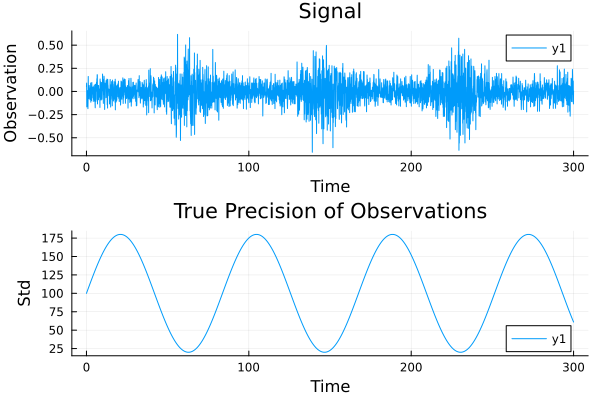

In [4]:
rng = StableRNG(1234)
time_points = 0.0:0.1:300.0
unstationary_noise = 100 .+ 80 .* sin.(0.075 * time_points)
data_points = map(d -> rand(rng, NormalMeanPrecision(0.0, d[2])), zip(time_points, unstationary_noise))

p1 = plot(time_points, data_points, seriestype = :line, title = "Signal", xlabel = "Time", ylabel = "Observation")
p2 = plot(time_points, unstationary_noise, seriestype = :line, title = "True Precision of Observations", xlabel = "Time", ylabel = "Std")
plot(p1, p2, layout = (2, 1))

## Understanding the Generated Data

Let's examine the data we just generated:

The top plot shows our observations over time. These are random samples drawn from a normal distribution with mean 0 and a time-varying precision.

The bottom plot shows how the true precision (inverse variance) of the noise changes over time:
  - It oscillates sinusoidally between approximately 20 and 180
  - The period of oscillation is relatively slow, allowing us to track the changes
  - This simulates real-world scenarios where noise characteristics drift over time

This setup creates an interesting challenge for our inference: the model needs to adapt its beliefs about the noise precision as the true value changes. A static model would try to find a single "best" precision value, while we want our model to track these changes over time.


Let's create a simple model that tracks a non-stationary signal. We'll use a Kalman filter with a state variable and an unknown noise precision that we'll try to infer. The model assumes that the state evolves with small random changes (controlled by a fixed precision of 1000.0) and generates observations with unknown precision.

In [5]:
@model function kalman_filter(observation, state_prior_mean, state_prior_var, obs_noise_shape, obs_noise_rate)
    state_prior ~ Normal(mean = state_prior_mean, var = state_prior_var)
    next_state ~ Normal(mean = state_prior, precision = 1000.0)
    noise_precision ~ Gamma(shape = obs_noise_shape, rate = obs_noise_rate)
    observation ~ Normal(mean = next_state, precision = noise_precision)
end

Now let's set up the inference process. First, we'll create an update rule that specifies how the model parameters should be updated after each observation. This includes updating our beliefs about both the state of the system and the noise precision. We'll also define an initialization that sets reasonable starting values for our variables.


In [6]:
autoupdates_without_forgetting = @autoupdates begin
    # Update the state prior mean and variance
    state_prior_mean = mean(q(next_state))
    state_prior_var = var(q(next_state))
    # Update the noise precision
    obs_noise_shape = shape(q(noise_precision))
    obs_noise_rate = rate(q(noise_precision))
end

initialization = @initialization begin
    q(next_state) = NormalMeanPrecision(0.0, 1000.0)
    q(noise_precision) = GammaShapeRate(1.0, 0.005)
end

Initial state: 
  q(next_state) = NormalMeanPrecision{Float64}(μ=0.0, w=1000.0)
  q(noise_precision) = GammaShapeRate{Float64}(a=1.0, b=0.005)



Let's run the inference using our model and update rules. We'll use the `infer` function with our specified `kalman_filter` model and `autoupdates_without_forgetting` update rules. This will process our data points sequentially and track how the model's beliefs evolve over time.



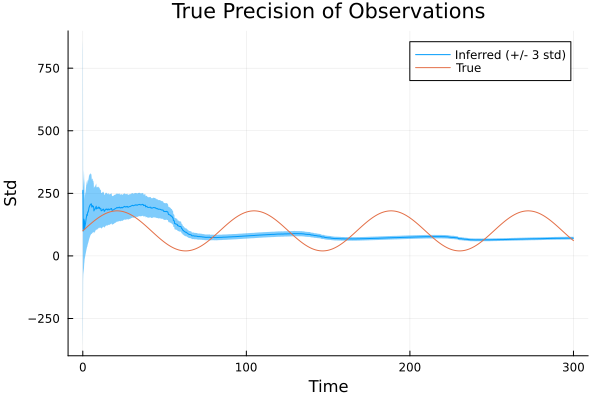

In [7]:
result_without_forgetting = infer(
    model = kalman_filter(),
    data = (observation = data_points,),
    autoupdates = autoupdates_without_forgetting,
    initialization = initialization,
    autostart = true,
    constraints = MeanField(),
    historyvars = (noise_precision = KeepLast(), ),
    iterations = 50,
    keephistory = length(data_points)
)

inferred_without_forgetting = result_without_forgetting.history[:noise_precision]

plot(time_points, mean.(inferred_without_forgetting), ribbon = 3std.(inferred_without_forgetting), seriestype = :line, title = "Inferred Noise Precision", xlabel = "Time", ylabel = "Std", label = "Inferred (+/- 3 std)")
plot!(time_points, unstationary_noise, seriestype = :line, title = "True Precision of Observations", xlabel = "Time", ylabel = "Std", label = "True")

The plot above shows how our model's inference of the noise precision compares to the true underlying precision. While the model successfully tracks the general magnitude of the precision, it fails to capture the non-stationary nature of the data. This is because our current inference approach assumes the noise precision is constant over time, leading to estimates that converge to a fixed value rather than adapting to the changing precision levels. This limitation motivates the need for a more flexible approach that can handle non-stationary dynamics.

## Introducing Forgetting Factors

To address the non-stationary nature of our data, we introduce a forgetting factor Γ. This factor controls how quickly the model forgets past observations, allowing it to focus more on recent data.

The forgetting factor Γ is a parameter that ranges between 0 and 1. A value of Γ = 1 means the model does not forget anything, while a value of Γ = 0 means the model forgets everything.
We will apply this technique to the parameters of the prior distribution of the noise precision. For this, we will create a callable structure that updates the parameters of the noise precision distribution based on the forgetting factor.

In [8]:
mutable struct UpdateParamsWithForgetting
    forgetting_factor::Float64
    previous_params::Union{Nothing, Tuple{Float64, Float64}}

    function UpdateParamsWithForgetting(; Γ = 0.99)
        return new(Γ, nothing)
    end
end

# Create a callable structure
# https://docs.julialang.org/en/v1/manual/methods/#Function-like-objects
# it allows us to have a local state, in this case `previous_params`
function (update::UpdateParamsWithForgetting)(gamma_posterior)

    if isnothing(update.previous_params)
        update.previous_params = (shape(gamma_posterior), rate(gamma_posterior))
        return (shape(gamma_posterior), rate(gamma_posterior))
    else 
        shape_prev, rate_prev = update.previous_params
        shape_current, rate_current = (shape(gamma_posterior), rate(gamma_posterior))
        shape_delta = shape_current - shape_prev
        rate_delta = rate_current - rate_prev

        @assert (shape_delta > 0) && (rate_delta > 0) "Shape and rate deltas must be strictly positive"
        
        Γ = update.forgetting_factor

        f_shape = shape_prev * Γ + shape_delta
        f_rate = rate_prev * Γ + rate_delta

        update.previous_params = (f_shape, f_rate)
        return (f_shape, f_rate)
    end

end

Next, we define a function that implements the forgetting factor mechanism in our inference process. The function `autoupdates_with_forgetting` takes a forgetting factor parameter and creates an update procedure that maintains the state estimates while applying forgetting to the noise precision parameters. It first updates the state prior mean and variance from the current beliefs, then creates an instance of our `UpdateParamsWithForgetting` structure with the specified forgetting factor. This structure will handle the gradual forgetting of old noise precision information. Finally, it updates the noise precision parameters using this forgetting mechanism, returning both the shape and rate parameters of the gamma distribution.

In [9]:
# we make it a function because it must create `obs_update` every time it is called
@autoupdates function autoupdates_with_forgetting(; forgetting_factor)
    # Update the state prior mean and variance
    state_prior_mean = mean(q(next_state))
    state_prior_var = var(q(next_state))

    # Update the forgetting factor, callable structure
    obs_update = UpdateParamsWithForgetting(Γ = forgetting_factor)

    # Update the noise precision, two at once
    obs_noise_shape, obs_noise_rate = obs_update(q(noise_precision))
end

autoupdates_with_forgetting (generic function with 1 method)

Everything is ready to run the inference with the forgetting factor.

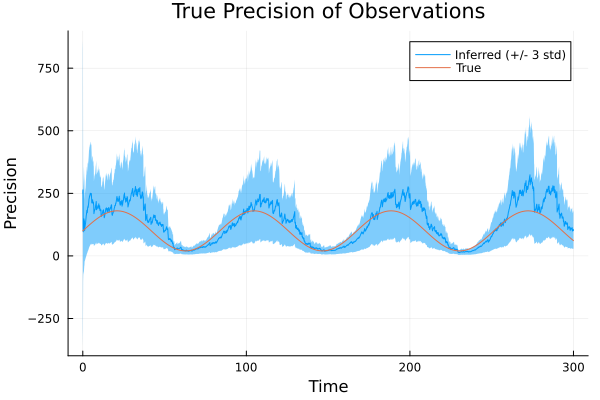

In [10]:
result_with_forgetting = infer(
    model = kalman_filter(),
    data = (observation = data_points,),
    autoupdates = autoupdates_with_forgetting(forgetting_factor = 0.97),
    initialization = initialization,
    autostart = true,
    constraints = MeanField(),
    historyvars = (noise_precision = KeepLast(), ),
    iterations = 100,
    keephistory = length(data_points)
)

inferred_with_forgetting = result_with_forgetting.history[:noise_precision]

plot(time_points, mean.(inferred_with_forgetting), ribbon = 3std.(inferred_with_forgetting), seriestype = :line, title = "Inferred Noise Precision", xlabel = "Time", ylabel = "Std", label = "Inferred (+/- 3 std)")
plot!(time_points, unstationary_noise, seriestype = :line, title = "True Precision of Observations", xlabel = "Time", ylabel = "Precision", label = "True")

The plot shows how the forgetting factor mechanism allows the model to adapt to changes in the noise precision over time. The blue line and shaded area represent the inferred noise precision with uncertainty bounds (±3 standard deviations), while the orange line shows the true underlying noise precision that was used to generate the data. We can see that the model successfully tracks the changing noise levels, though with some lag due to the forgetting factor. The uncertainty bounds (shaded area) indicate the model's confidence in its estimates, which varies as it adapts to the non-stationary noise. This demonstrates that our forgetting factor approach effectively handles time-varying noise characteristics in the system.

The result depends on the choice of the forgetting factor. A higher forgetting factor (closer to 1) means the model has a longer memory and adapts more slowly to changes, while a lower value makes it more responsive but potentially more sensitive to noise. Here we try a forgetting factor of 0.99 instead of the previous 0.97 to see how it affects the inference.

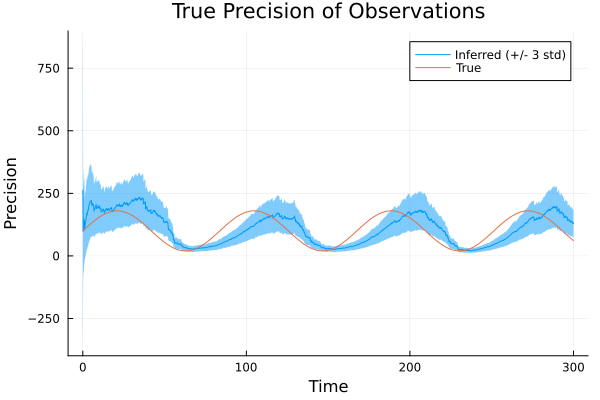

In [11]:
result_with_forgetting = infer(
    model = kalman_filter(),
    data = (observation = data_points,),
    autoupdates = autoupdates_with_forgetting(forgetting_factor = 0.99),
    initialization = initialization,
    autostart = true,
    constraints = MeanField(),
    historyvars = (noise_precision = KeepLast(), ),
    iterations = 100,
    keephistory = length(data_points)
)

inferred_with_forgetting = result_with_forgetting.history[:noise_precision]

plot(time_points, mean.(inferred_with_forgetting), ribbon = 3std.(inferred_with_forgetting), seriestype = :line, title = "Inferred Noise Precision", xlabel = "Time", ylabel = "Std", label = "Inferred (+/- 3 std)")
plot!(time_points, unstationary_noise, seriestype = :line, title = "True Precision of Observations", xlabel = "Time", ylabel = "Precision", label = "True")

With a higher forgetting factor of 0.99, we can observe that the model adapts more slowly to changes in the noise precision compared to the previous case with 0.97. This results in smoother estimates but increased lag in tracking sudden changes. The trade-off between responsiveness and stability is evident - while the 0.99 forgetting factor provides more stable estimates by being less sensitive to temporary fluctuations, it takes longer to adapt to genuine changes in the underlying noise characteristics.

This example demonstrates how forgetting factors can be effectively used in online inference to handle non-stationary data. By carefully choosing the forgetting factor, we can balance between the model's ability to retain historical information and its adaptability to changing conditions. This approach is particularly valuable in real-world applications where system characteristics evolve over time and require continuous adaptation of the inference process.